In [1]:
import numpy as np
import pandas as pd
from pylab import mpl, plt
import os
import seaborn as sns

os.chdir('data')

As in the first work we get the historic end-of-day closing prices of four stocks.

,AAPL,IBM,MSFT,NKE
date,,,,
2014-02-21,68.9821,152.3849,33.7870,36.0905
2014-02-24,69.2841,152.9351,33.5290,36.7323
2014-02-25,68.5631,152.7517,33.3956,36.8597
2014-02-26,67.9446,153.4436,33.3333,37.0060
2014-02-27,69.2999,154.4523,33.6803,36.9302


,AAPL,IBM,MSFT,NKE
min,67.94,104.41,33.33,33.53
mean,128.63,140.75,62.48,55.82
max,230.28,166.96,114.62,85.40
std,38.22,12.80,23.72,12.12


<AxesSubplot: xlabel='date'>

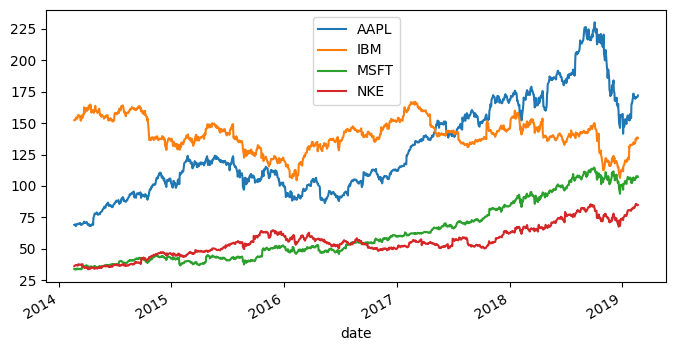

In [2]:
# get EOD data
eod = pd.DataFrame()

for name in ['AAPL','IBM','MSFT','NKE']:
    raw = pd.read_csv(name+'.csv', index_col=0, parse_dates=True)
    raw = raw[['close']]
    raw.rename({'close': name}, axis=1, inplace=True)
    eod = pd.concat([eod, raw], axis=1)

display(eod.head())
display(eod.aggregate([min, np.mean, max, np.std]).round(2))
eod.plot(figsize=(8,4))

4.1

As a first strategy we consider the classic dual simple moving averages, ie. having a moving average with a small window and another with a large on.
The strategy says to buy when the small SMA is stronger than the large one and sell otherwise.
This is shown in the plot by the dotted line which shows buying at 1 and selling at -1.
For a first example we set the small window to be 42 closes (shown in green in the diagram) and the large window to 252 closes (in red).

<AxesSubplot: >

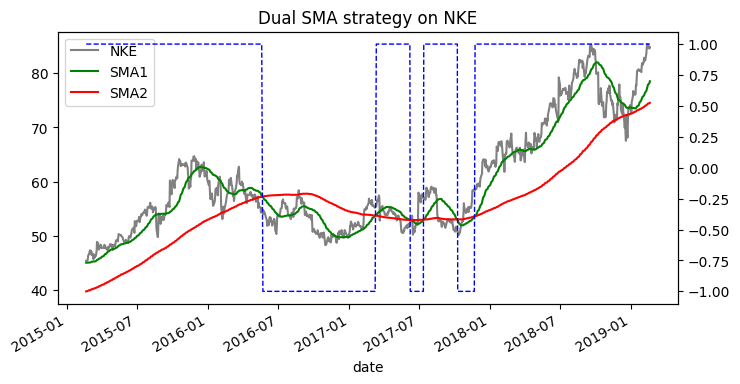

In [3]:
# Dual simple moving averages
nke = pd.DataFrame(eod['NKE'])
nke['SMA1'] = nke.NKE.rolling(window=42).mean()
nke['SMA2'] = nke.NKE.rolling(window=252).mean()

fig, ax = plt.subplots()
fig.set_size_inches(8,4)

nke.dropna(inplace=True,axis=0,how='any')

nke.plot(ax=ax, style=['grey','g','r'], title='Dual SMA strategy on NKE')

nke['strategy'] = np.where(nke.SMA1 > nke.SMA2, 1, -1)

nke.strategy.plot(ax=ax, secondary_y='strategy', style='b--',lw=1)

Now that we have a strategy we want to consider whether or not it has better returns than simply investing in NKE at the start and waiting.
Clearly the strategy is not great since the returns are smaller than having simply done nothing.

In [4]:
# compute returns
nke['ret'] = np.log(nke.NKE / nke.NKE.shift(1))
print(f"Investing and doing nothing returns {round(np.exp(nke.ret.sum()),3)}.")

nke['SMA_ret'] = nke.ret * nke.strategy.shift(1)
print(f"Dual SMA strategy returns {round(np.exp(nke.SMA_ret.sum()),3)}.")

Investing and doing nothing returns 1.871.
Dual SMA strategy returns 1.142.


The window sizes were rather arbitrary and it would be interesting to find which pair of window sizes would offer the best returns.
For this we simply brut force within a reasonable range.
We also implement an idea of cost to disadvantage the strategies that would simply try to buy and sell as fast as possible whenever the market changed.
This cost is simply applied as a deduction to the total return for everytime we have to buy or sell.

,small_w,large_w,returns
68,27,80,175.333576
56,22,80,175.333576
92,37,80,173.333576
80,32,80,173.333576
81,32,85,172.907864
69,27,85,172.907864
88,37,60,171.658036
32,12,80,171.333576
44,17,80,171.333576
71,27,95,171.165632


<AxesSubplot: xlabel='large_w', ylabel='small_w'>

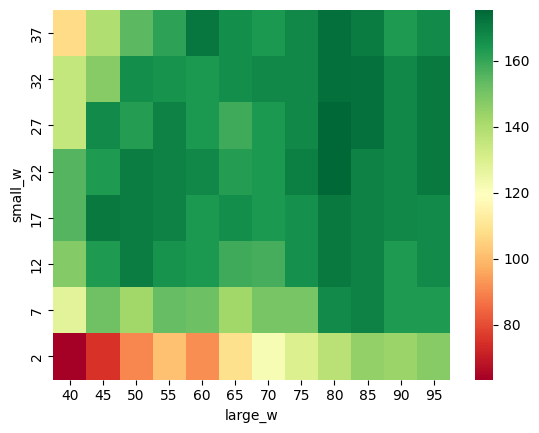

In [15]:
# brute force for best windows

nke = pd.DataFrame(eod['NKE'])

returns = pd.DataFrame(columns=['small_w','large_w','returns'])

for small_w in range(2,40, 5):
    for large_w in range(40, 100, 5):
        nke = pd.DataFrame(eod['NKE'])
        nke['SMA1'] = nke.NKE.rolling(window=small_w).mean()
        nke['SMA2'] = nke.NKE.rolling(window=large_w).mean()

        nke.dropna(inplace=True,axis=0,how='any')

        nke['strategy'] = np.where(nke.SMA1 > nke.SMA2, 1, -1)

        nke['cost'] = np.abs(nke.strategy - nke.strategy.shift(1))

        nke['ret'] = np.log(nke.NKE / nke.NKE.shift(1))

        total_ret = np.exp(nke.ret.sum())*nke.NKE[-1] - nke.cost.sum()

        returns = pd.concat([returns, pd.DataFrame(
            {'small_w': small_w,
             'large_w': large_w,
             'returns': total_ret} ,index=[0])],ignore_index=True)

display(returns.sort_values(by='returns',ascending=False).head(10))

pivot = returns.pivot_table(values='returns',index='small_w',columns='large_w')
pivot.sort_index(ascending=False,inplace=True)
sns.heatmap(pivot,cmap='RdYlGn')

Looking at the best strategies we see the small window being 22 or 27 and the large window being 80 is optimal, however many of the strategies are really almost as strong.
Finally we finishing by looking at this optimal strategy over time.

<AxesSubplot: >

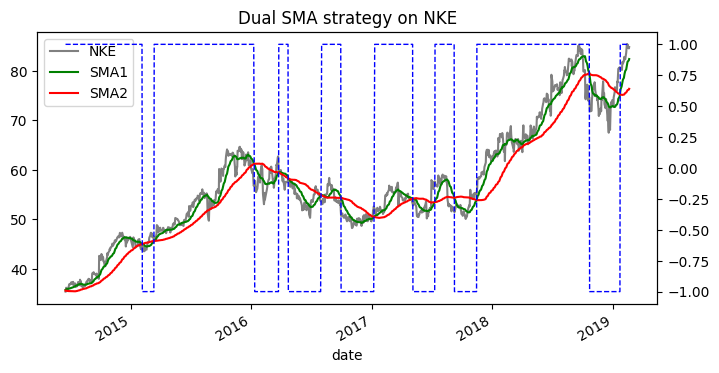

In [16]:
# Dual simple moving averages
nke = pd.DataFrame(eod['NKE'])
nke['SMA1'] = nke.NKE.rolling(window=22).mean()
nke['SMA2'] = nke.NKE.rolling(window=80).mean()

fig, ax = plt.subplots()
fig.set_size_inches(8,4)

nke.dropna(inplace=True,axis=0,how='any')

nke.plot(ax=ax, style=['grey','g','r'], title='Dual SMA strategy on NKE')

nke['strategy'] = np.where(nke.SMA1 > nke.SMA2, 1, -1)

nke.strategy.plot(ax=ax, secondary_y='strategy', style='b--',lw=1)

4.2